<a href="https://colab.research.google.com/github/Jancerem/PDI-LAB/blob/main/LAB_PDI_Practica4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4.- Segmentación Óptima
**Miembros:**
*  Ingrid Edith Martínez Andrade - 1995361
*  Jan Carlos Morales Rivera - 1905790

# Objetivo
Realizar la segmentación de un área de interés en una imagen médica por medio de segmentación óptima.

# Segmentación sencilla VS Segmentación óptima
**Subir imagen de prueba**

In [42]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]

img = cv2.imread('/content/' + filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Saving IMG_1133_Fotor.jpg to IMG_1133_Fotor (1).jpg


Se cargo la imagen y se paso del formato BGR a RGB.


**Importación de librerías**

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize # para algoritmo de optimización

# Parte I - Segmentación Sencilla

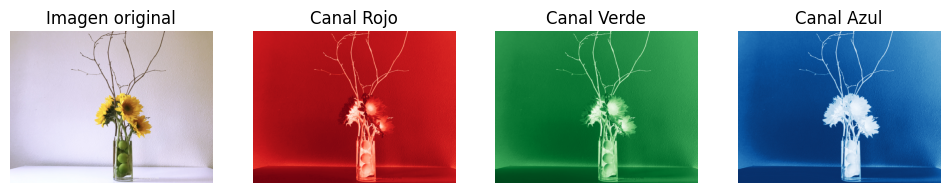

In [44]:
# Separar canales
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

# Mostrar los canales por separado
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(R, cmap='Reds')
plt.title('Canal Rojo')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(G, cmap='Greens')
plt.title('Canal Verde')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(B, cmap='Blues')
plt.title('Canal Azul')
plt.axis('off')
plt.show()

Se extrajeron individualmente los canales Red, Green y Blue.

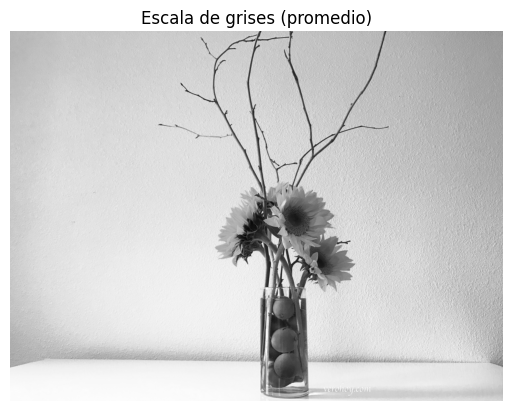

In [45]:
# Convertir a escala de grises promediando canales
gray_avg = ((R.astype(np.float32) + G + B) / 3).astype(np.uint8)

# Mostrar imagen en escala de grises
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')
plt.show()

Mediante un promedio de los canales se convirtio a escala de grises.

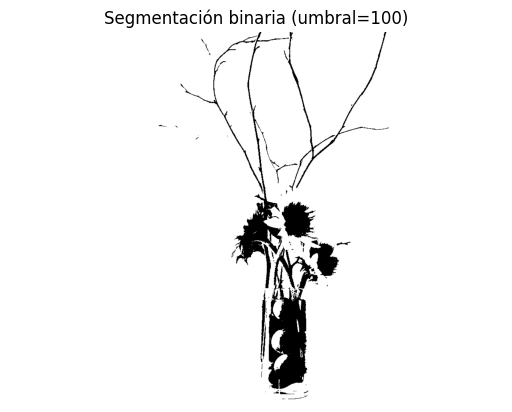

In [46]:
# Umbral para segmentación
umbral = 100
_, segmentada = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)

# Mostrar imagen segmentada
plt.imshow(segmentada, cmap='gray')
plt.title(f'Segmentación binaria (umbral={umbral})')
plt.axis('off')
plt.show()

Mediante una segmentacion binaria, se establecio un valor de umbral donde cualquier pixel con un valor mayor o igual a 100 sera considerado como blanco, y lo demás será negro.

# Parte II - Segmentación Óptima

**Objetivo:** Encontrar los coeficientes óptimos [w_𝑟, 𝑤_𝑔, 𝑤_𝑏] para convertir una imagen RGB a escala de grises.

**Ejercicio 1: Extracción RGB**



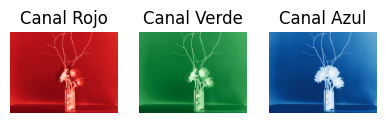

In [52]:
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

plt.subplot(1, 4, 2)
plt.imshow(R, cmap='Reds')
plt.title('Canal Rojo')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(G, cmap='Greens')
plt.title('Canal Verde')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(B, cmap='Blues')
plt.title('Canal Azul')
plt.axis('off')
plt.show()

Se extraen por separado los tres canales de color de una imagen en formato RGB, después se muestran en pantalla para comproban hayan funcionado correctamente.

**Ejercicio 2: Obtención de pesos optimos**

In [55]:
# Normalizar canales entre 0 y 1
R_norm = R.astype(np.float32) / 255
G_norm = G.astype(np.float32) / 255
B_norm = B.astype(np.float32) / 255

# Función objetivo: varianza negativa (porque minimize() minimiza)
def grayscale_variance(weights):
    w_r, w_g, w_b = weights
    gray = w_r * R_norm + w_g * G_norm + w_b * B_norm
    gray_normalized = (gray - gray.min()) / (gray.max() - gray.min())
    return -np.var(gray_normalized)  # Negativo para maximizar

# Restricción: suma de pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Límites de cada peso: entre 0 y 1
bounds = [(0, 1), (0, 1), (0, 1)]

# Valor inicial
initial_weights = [0.33, 0.33, 0.34]

# Optimización
result = minimize(grayscale_variance, initial_weights, method='SLSQP',
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Pesos óptimos:", optimal_weights)

Pesos óptimos: [3.68567848e-16 1.38777878e-16 1.00000000e+00]


Se obtienen los pesos optimos de la imagen.

**Ejercicio 3: Detección de contornos**

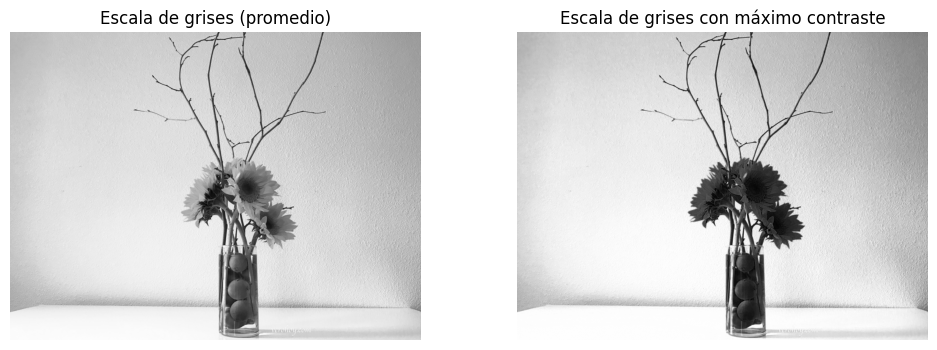

In [56]:
# Crear imagen en escala de grises con pesos óptimos
gray_optimal = optimal_weights[0] * R_norm + optimal_weights[1] * G_norm + optimal_weights[2] * B_norm
gray_optimal = (gray_optimal * 255).astype(np.uint8)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(gray_optimal, cmap='gray')
plt.title('Escala de grises con máximo contraste')
plt.axis('off')
plt.show()

Se creo una imagen en esala de grises con los pesos obtmos, mostrando una comparacion entre aquella obtenida directamente y aquella de manera óptima.

* **Ejercicio 4: Segmentación estándar vs óptima**

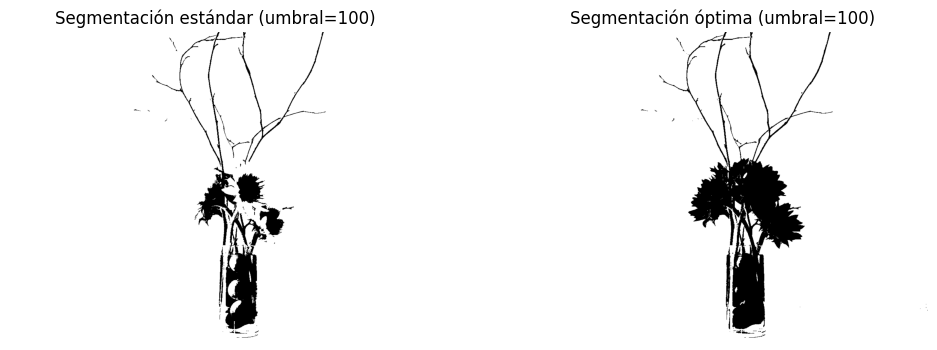

In [40]:
# Segmentar ambas imágenes con un mismo umbral
umbral = 100
_, seg_standard = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)
_, seg_optimal = cv2.threshold(gray_optimal, umbral, 255, cv2.THRESH_BINARY)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(seg_standard, cmap='gray')
plt.title(f'Segmentación estándar (umbral={umbral})')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(seg_optimal, cmap='gray')
plt.title(f'Segmentación óptima (umbral={umbral})')
plt.axis('off')
plt.show()

Resultados de la comparación entre segmentación estandar y óptima.

# Parte III - Analisis de Tumor.

Importación de librerias e imagen.

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Subir imagen manualmente
uploaded = files.upload()

# Leer imagen en blanco y negro (escala de grises)
for fn in uploaded.keys():
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)

Saving Te-me_0015.jpg to Te-me_0015 (5).jpg


Mostrar imagen origianl:

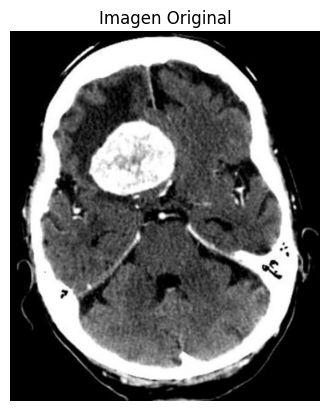

In [58]:
# Mostrar imagen original
plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

Segmentación por umbralización de 230.

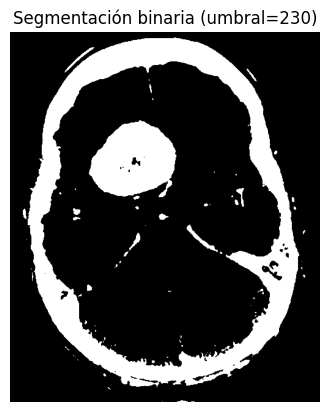

In [130]:
# --- Segmentación: Umbralización ---
# Usar umbral automático (Otsu)
umbral = 230
_, segmented = cv2.threshold(img, umbral, 255, cv2.THRESH_BINARY)

# Mostrar imagen segmentada
plt.imshow(segmentada, cmap='gray')
plt.title(f'Segmentación binaria (umbral={umbral})')
plt.axis('off')
plt.show()

Eliminación de ruido mediante herramienta de morfología.

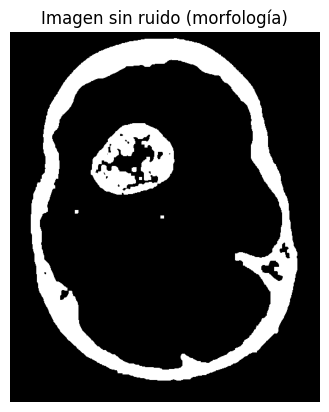

In [131]:
# --- Eliminación de ruido (morfología) ---
# Operación morfológica: apertura (eliminar puntos aislados)
kernel = np.ones((3, 3), np.uint8)
clean = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, kernel, iterations=2)

plt.imshow(clean, cmap='gray')
plt.title('Imagen sin ruido (morfología)')
plt.axis('off')
plt.show()

Encontrar contornos y su jerarquía, para con esto establecer cual será el contorno del craneo (el mas grande) y el contorno que se encuentre en el rango de 50 y 20000 sera el contorno del tumor.

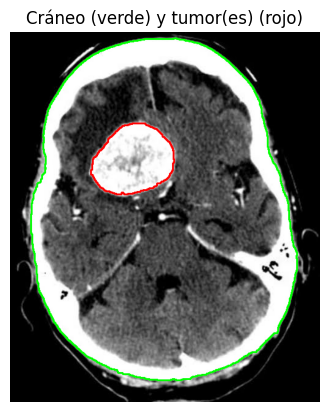

Área total del tumor en píxeles: 167364.50


In [173]:
# Encontrar contornos y jerarquía
contours, hierarchy = cv2.findContours(clean, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convertir a color para dibujar
img_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Obtener el índice del contorno más grande (cráneo)
areas = [cv2.contourArea(c) for c in contours]
max_idx = np.argmax(areas)

# Dibujar cráneo en verde
cv2.drawContours(img_contours, [contours[max_idx]], -1, (0, 255, 0), 2)

# Extraer jerarquía real
hierarchy = hierarchy[0]

# Función para obtener todos los descendientes de un contorno (tumores o huecos dentro del cráneo)
def get_all_children(parent_idx, hierarchy):
    children = []
    child = hierarchy[parent_idx][2]  # Primer hijo
    while child != -1:
        children.append(child)
        # Recursivamente agregamos hijos de este hijo
        children.extend(get_all_children(child, hierarchy))
        child = hierarchy[child][0]  # Hermano siguiente
    return children

# Obtener todos los hijos y descendientes del cráneo
tumor_indices = get_all_children(max_idx, hierarchy)

# Dibujar tumores en rojo
for idx in tumor_indices:
    # Para filtrar ruido muy pequeño, considerar solo contornos grandes (ajustar mínimo área)
    if (cv2.contourArea(contours[idx]) < 20000 and cv2.contourArea(contours[idx]) > 10000):
        cv2.drawContours(img_contours, [contours[idx]], -1, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title('Cráneo (verde) y tumor(es) (rojo)')
plt.axis('off')
plt.show()

# Calcular área total tumor sumando solo contornos filtrados
tumor_area = sum(cv2.contourArea(contours[i]) for i in tumor_indices if cv2.contourArea(contours[i]) > 50)
print(f"Área total del tumor en píxeles: {tumor_area:.2f}")

Con el objetivo de mostrar el craneo y tumor, se hizo la carga de la imagen en blanco y negro, procediendo a una segmentación por umbral de 230, continuando con una limpieza morfológica, para proceder a entrar con la detección de contornos donde se encontraron los contors enxternos en la imagen limpia, después se clasificaron los contornos por tamaño, el más grande de color verde sería el craneo y el tumor cuando esta entre 50 y 20000 pixeles de área.

# Conclusión grupal

A través del procesamiento digital de imágenes médicas, se logró segmentar correctamente una imagen en escala de grises para identificar el contorno del cráneo y del tumor cerebral. Utilizando técnicas como umbralización, operaciones morfológicas y detección de contornos con filtrado por área, se pudo eliminar el ruido y aislar las regiones de interés. Esta metodología permite destacar visualmente estructuras relevantes dentro de una imagen médica, facilitando el análisis clínico y automatizado del tumor.

En conjunto con lo visto en la pruenba donde se utilizo un girasol como practica para utilizar herramientas de segmentación óptima, esta práctica demuestra cómo herramientas de visión por computadora pueden aplicarse eficazmente en contextos médicos para apoyar el diagnóstico.